In [71]:
import os
import pandas as pd
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer


In [72]:
## consts :

SAMPLE_FREQ = 50 
FILE_MARGINES = 5* SAMPLE_FREQ  ## number of samples to ignore in the  start and in the end of the file (5 seconds )  
WINDOW_SIZE = 128  ## sliding window size 

DEVICE_MODE_LABELS = ['pocket','swing','texting','whatever'] 
USER_MODE_LABELS = ['walking','fastwalking','stairs','static','whatever'] 

FEATURES = ['agforce','agyro','mgforce','mgyro','vgforce','vgyro','maxgforce','maxgyro','mingforce','minxgyro','ampgforce','ampxgyro']


### Calulates high level features and add to given data frame add norm feature for g-force , gyro vectors calculates additional statistics features  on the norm properties using sliding window fill NaN values 

In [73]:
def addFeatures(df):
    
    ## norm calculations :
    df['gforce'] = np.sqrt(df['gfx']**2 + df['gFy']**2 + df['gFz']**2) 
    df['gyro'] = np.sqrt(df['wx']**2 + df['wy']**2 + df['wz']**2)     
    
    ## calculates statistics features on rolling window :
    
    df['agforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).mean()
    df['agyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).mean()

    df['mgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).median()
    df['mgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).median()

    df['vgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()
    df['vgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()

    df['maxgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).max()
    df['maxgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).max()

    df['mingforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).min()
    df['minxgyro']  = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).min()

    df['ampgforce'] = df['maxgforce'] - df['mingforce']
    df['ampxgyro']  = df['maxgyro'] - df['gyro']
    
    ## TODO : peaks detection , 
 

### Read csv data file , add label colomn by parsing the file name  add high level features , crop file edges  Todo : normlize , remove dc 

In [74]:
def loadFile(root,file):
    print 'loading : ' , file 
    data=pd.read_csv(os.path.join(root,file))
    
    ## usefull property : 
    data['source']=file  

    ## default label values in case file name not contains label  
    data['devicemodeDescription']=DEVICE_MODE_LABELS[-1] ## 'whatever' label 
    data['devicemode'] = len(DEVICE_MODE_LABELS)

    ## search device mode label in file name and add as new properties :
    for label in DEVICE_MODE_LABELS:
        if label.lower() in file.lower():  
            data['devicemodeDescription']=label         ## label name 
            data['devicemode'] = DEVICE_MODE_LABELS.index(label)    ## label index 
            break
    
    ## add high level features 
    addFeatures(data)
    
    print len(data) , ' samples loaded '
    print 'all records labeld as ', data['devicemodeDescription'][0]
        
    ## crop samples from start and from the end of the file :
    data.drop(data.index[range(0,FILE_MARGINES)],axis=0,inplace=True)
    data.drop(data.index[range(-FILE_MARGINES,-1)],axis=0,inplace=True)   
    print len(data) , ' samples after cropping ' , FILE_MARGINES , 'samples from start-end of the file  '
    return data

In [75]:
def loadFiles(inputDir):
    print 'loading files from : ' , inputDir 
    return pd.concat([loadFile(inputDir,f) for f in os.listdir(inputDir) if f.lower().endswith('.csv')])  

In [76]:
rdf = loadFiles(r'../all-data/utf8')
print '========================================================='
print 'total train samples ' , len(rdf) 

loading files from :  ../all-data/utf8
loading :  SwingRightPhoneDownScBody.csv
9258  samples loaded 
all records labeld as  swing
8759  samples after cropping  250 samples from start-end of the file  
loading :  swing_walk2017-09-0316.04.51.csv
11775  samples loaded 
all records labeld as  swing
11276  samples after cropping  250 samples from start-end of the file  
loading :  texting_walk2017-09-0315.53.12.csv
4329  samples loaded 
all records labeld as  texting
3830  samples after cropping  250 samples from start-end of the file  
loading :  PocketLeftStairsUp3.csv
1219  samples loaded 
all records labeld as  pocket
720  samples after cropping  250 samples from start-end of the file  
loading :  swingLeftHandPhoneDownScBody.csv
10608  samples loaded 
all records labeld as  swing
10109  samples after cropping  250 samples from start-end of the file  
loading :  SwingRightPhoneDown.csv
7561  samples loaded 
all records labeld as  swing
7062  samples after cropping  250 samples from st

In [77]:
rdf.describe()

,Bx,By,Bz,I,Latitude,Longitude,Speed (m/s),Unnamed: 11,Unnamed: 12,Unnamed: 17,...,mgyro,mingforce,minxgyro,p,time,vgforce,vgyro,wx,wy,wz
count,130571.000000,130571.000000,130571.000000,69778.000000,15706.000000,15706.000000,15706.000000,0.0,0.0,0.0,...,130571.000000,130571.000000,130571.000000,109279.000000,130571.000000,1.305710e+05,1.305710e+05,130571.000000,130571.000000,130571.000000
mean,1.986717,12.570263,-6.945136,2270.310112,24.843007,26.677360,1.041270,NaN,NaN,NaN,...,1.435178,0.698914,0.498060,976.920210,102.995014,7.440947e-02,5.459917e-01,0.002345,0.004363,0.001885
std,24.832349,23.279281,22.305891,4209.896212,14.108547,15.150291,0.823378,NaN,NaN,NaN,...,0.792175,0.152582,0.349781,3.726151,65.528174,4.828065e-02,7.773395e-01,0.791472,1.034476,1.309384
min,-50.332600,-39.480000,-47.100000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.000316,0.344802,0.000224,968.814600,3.994000,1.101760e-07,2.620800e-08,-6.055000,-11.138600,-4.949600
25%,-16.500000,-6.292750,-26.507600,0.000000,32.854418,35.279376,0.000000,NaN,NaN,NaN,...,0.737756,0.592269,0.196065,977.880600,47.911000,3.765992e-02,1.082938e-01,-0.390800,-0.341300,-0.818500
50%,4.890400,20.393400,-16.645800,0.000000,32.854632,35.280320,1.500000,NaN,NaN,NaN,...,1.550985,0.693079,0.469738,978.492400,93.285000,6.865760e-02,3.238199e-01,0.000100,0.000100,0.000000
75%,24.691800,31.419400,14.259300,320.000000,32.854936,35.281420,1.750000,NaN,NaN,NaN,...,2.052036,0.784944,0.749069,978.732600,148.230000,1.143224e-01,6.412364e-01,0.337600,0.380700,0.834200
max,288.967900,65.843200,43.527200,10240.000000,32.857075,35.282055,2.250000,NaN,NaN,NaN,...,3.491192,1.012221,1.746989,980.680700,377.232000,2.311800e-01,7.656162e+00,5.633500,9.266700,5.048500


### visualize

In [78]:
cor_mat = rdf[FEATURES + ['devicemode']] .corr()
cor_mat

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro,devicemode
agforce,1.000000,0.625125,0.825650,0.732789,0.578337,0.086810,0.751228,0.304382,-0.060578,0.536806,0.609654,0.038463,-0.209917
agyro,0.625125,1.000000,0.511003,0.971507,0.591793,0.662819,0.589362,0.878796,-0.471358,0.737017,0.623888,0.584113,-0.716878
mgforce,0.825650,0.511003,1.000000,0.602579,0.502284,0.074701,0.559136,0.246040,-0.187020,0.409656,0.502520,0.030365,-0.117533
mgyro,0.732789,0.971507,0.602579,1.000000,0.617206,0.527663,0.653489,0.773408,-0.411753,0.712830,0.653679,0.459748,-0.651823
vgforce,0.578337,0.591793,0.502284,0.617206,1.000000,0.182243,0.882680,0.388177,-0.707731,0.597806,0.935003,0.165593,-0.259248
vgyro,0.086810,0.662819,0.074701,0.527663,0.182243,1.000000,0.077658,0.901017,-0.330835,0.314624,0.174520,0.811690,-0.570002
maxgforce,0.751228,0.589362,0.559136,0.653489,0.882680,0.077658,1.000000,0.313494,-0.496876,0.629328,0.954530,0.071500,-0.198383
maxgyro,0.304382,0.878796,0.246040,0.773408,0.388177,0.901017,0.313494,1.000000,-0.472483,0.559830,0.408038,0.806709,-0.720054
mingforce,-0.060578,-0.471358,-0.187020,-0.411753,-0.707731,-0.330835,-0.496876,-0.472483,1.000000,-0.406673,-0.732994,-0.345522,0.275350
minxgyro,0.536806,0.737017,0.409656,0.712830,0.597806,0.314624,0.629328,0.559830,-0.406673,1.000000,0.632995,0.307381,-0.475540


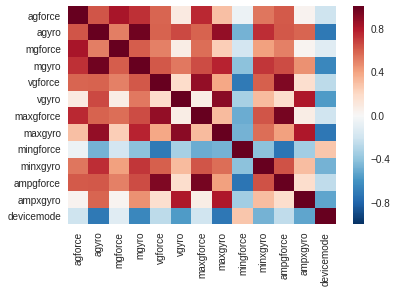

In [79]:
sns.heatmap(cor_mat)

## split train & test data

In [80]:
# take only relevants features :
df = rdf[FEATURES]
df.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,1.314327,2.358790,1.301040,2.631593,0.132965,0.680789,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
251,1.315529,2.364974,1.304636,2.631593,0.132745,0.674055,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
252,1.316730,2.371158,1.304636,2.631593,0.132521,0.667243,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
253,1.319528,2.373912,1.304636,2.631593,0.131412,0.662967,2.094436,3.294189,0.74283,0.618111,1.351606,1.515887
254,1.322326,2.376665,1.304636,2.631593,0.130288,0.658675,2.094436,3.294189,0.74283,0.618111,1.351606,1.515887


In [81]:
x_train, x_test, y_train, y_test = train_test_split(df, rdf.devicemode, test_size=0.4, random_state=42,stratify=rdf.devicemode)

[[13515    25     3]
 [   16 26749     8]
 [    7    10 11896]]


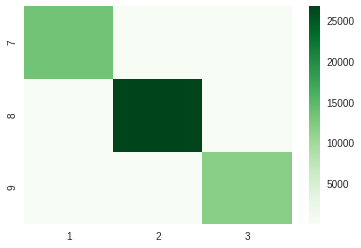

In [82]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(x_train,y_train)
knn5_pred = knn5.predict(x_test)
print(confusion_matrix(y_pred=knn5_pred,y_true=y_test))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_pred,y_true=y_test),cmap='Greens')

In [83]:
print('classification report results:\r\n' + classification_report(y_pred=knn5_pred,y_true=y_test))

classification report results:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13543
          1       1.00      1.00      1.00     26773
          2       1.00      1.00      1.00     11913

avg / total       1.00      1.00      1.00     52229



In [84]:
accuracy_score(y_test,knn5_pred)

0.99867889486683648

## cross_validation (  group by source proprty ) 
K-fold iterator variant with non-overlapping groups.
The same group will not appear in two different folds
The number of distinct groups has to be at least equal to the number of folds.
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [98]:
forest = RandomForestClassifier()
tree = DecisionTreeClassifier()
knn5 = KNeighborsClassifier(n_neighbors=5)

In [99]:
def CalcKFoldAccuracy(classifier,X,Y, scoring,k):
    group_kfold = GroupKFold(n_splits=k) 
    groups_itr = group_kfold.split(x_train, y_train, groups=rdf.source)    
    return cross_val_score(classifier, X, Y, cv=groups_itr, scoring=scoring)

In [101]:
k=5
x_train= df
y_train = rdf.devicemode

scoring='accuracy' 
print ('KNN : ')
print (CalcKFoldAccuracy(knn5,x_train,y_train,scoring,k))
print ('RF : ')
print (CalcKFoldAccuracy(forest,x_train,y_train, scoring,k))
print ('Tree : ')
print (CalcKFoldAccuracy(tree,x_train,y_train, scoring,k))

KNN : 
[ 0.91291     0.74365259  0.69480322  0.93657732  0.80059264]
RF : 
[ 0.83475828  0.77241221  0.75167148  0.9702826   0.83546708]
Tree : 
[ 0.835963    0.77601195  0.74585929  0.96621803  0.78516886]


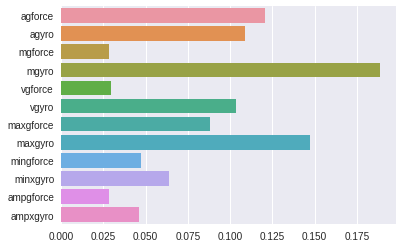

In [105]:
forest.fit(x_train,y_train)
sns.barplot(y=x_train.columns,x=forest.feature_importances_,orient="h" )

In [107]:
sns.barplot?

### validate on file outside of the train bucket 

In [108]:
rvl = loadFiles(r'../raw-data/validation/utf8')
print '========================================================='
print 'total validation samples ' , len(rvl) 

loading files from :  ../raw-data/validation/utf8
loading :  swing3.csv
4931  samples loaded 
all records labeld as  swing
4432  samples after cropping  250 samples from start-end of the file  
loading :  Pocket2.csv
8050  samples loaded 
all records labeld as  pocket
7551  samples after cropping  250 samples from start-end of the file  
loading :  Texting2.csv
4268  samples loaded 
all records labeld as  texting
3769  samples after cropping  250 samples from start-end of the file  
total validation samples  15752


In [109]:
rvl.dropna(axis=1,inplace=True)
rvl.drop("source",axis=1).head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,...,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,5.575,-0.7754,-0.6393,-0.0722,0.0342,-0.0166,-0.1185,978.6745,4.1412,43.5471,...,0.998835,0.305435,0.039810,0.967789,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
251,5.576,-0.8192,-0.6118,-0.1383,0.0342,-0.0166,-0.1185,978.6745,4.1412,43.5471,...,0.999904,0.305435,0.039242,0.966377,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
252,5.616,-0.8192,-0.6118,-0.1383,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,1.000973,0.305435,0.038664,0.962026,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
253,5.617,-0.8192,-0.6118,-0.1383,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,1.000973,0.305435,0.037927,0.957503,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
254,5.638,-0.7282,-0.6251,-0.0240,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,1.000973,0.305435,0.037203,0.952807,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323


In [110]:
vl = rvl[FEATURES]
vl.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,1.009667,0.826034,0.998835,0.305435,0.039810,0.967789,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
251,1.011935,0.814236,0.999904,0.305435,0.039242,0.966377,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
252,1.014203,0.804996,1.000973,0.305435,0.038664,0.962026,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
253,1.016724,0.795755,1.000973,0.305435,0.037927,0.957503,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
254,1.018685,0.786515,1.000973,0.305435,0.037203,0.952807,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323


In [111]:
k=5
scoring ='accuracy'

print ('KNN : ')
knn5.fit(x_train,y_train)
knn5_val = knn5.predict(vl)
print(confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode))
##sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode),cmap='Greens')
print(classification_report(y_pred=knn5_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,knn5_val)
print '========================================================='

print ('RF : ')
forest.fit(x_train,y_train)
forest_val = forest.predict(vl)
print(confusion_matrix(y_pred=forest_val,y_true=rvl.devicemode))
print(classification_report(y_pred=forest_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,forest_val)
print '========================================================='

print ('TREE : ')
tree.fit(x_train,y_train)
tree_val = tree.predict(vl)
print(classification_report(y_pred=tree_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,tree_val)

KNN : 
[[5467 2042   42]
 [  31 4356   45]
 [   0    2 3767]]
             precision    recall  f1-score   support

          0       0.99      0.72      0.84      7551
          1       0.68      0.98      0.80      4432
          2       0.98      1.00      0.99      3769

avg / total       0.90      0.86      0.86     15752

RF : 
[[1042 6464   45]
 [  11 4383   38]
 [   0   12 3757]]
             precision    recall  f1-score   support

          0       0.99      0.14      0.24      7551
          1       0.40      0.99      0.57      4432
          2       0.98      1.00      0.99      3769

avg / total       0.82      0.58      0.51     15752

TREE : 
             precision    recall  f1-score   support

          0       0.98      0.40      0.57      7551
          1       0.49      0.98      0.66      4432
          2       0.98      1.00      0.99      3769

avg / total       0.84      0.71      0.69     15752



0.70740223463687146

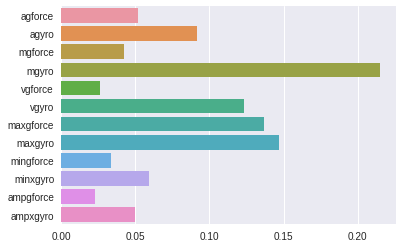

In [112]:
sns.barplot(y=vl.columns,x=forest.feature_importances_,orient="h" )

### Parameters tuning :

In [37]:
n_trees = range(10,200)
max_features = ['sqrt','log2']
cores =-1
param_dict = dict(n_estimators=n_trees, max_features=max_features)
grid = RandomizedSearchCV(forest, param_dict, cv=5, scoring='accuracy')

In [39]:
grid.fit(x_train,y_train)

KeyboardInterrupt: 

In [56]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.99991247169
{'n_estimators': 111, 'max_features': 'sqrt'}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=111, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [57]:
forset = RandomForestClassifier(n_estimators=grid.best_params_["n_estimators"],max_features =grid.best_params_["max_features"])
forest.fit(x_train, y_train)
forest_val = forest.predict(vl)
print(classification_report(y_pred=forest_val,y_true=rvl.devicemode))
print (accuracy_score(rvl.devicemode,forest_val))

             precision    recall  f1-score   support

          0       0.97      0.24      0.38      7551
          1       0.43      0.98      0.60      4432
          2       0.98      1.00      0.99      3769

avg / total       0.82      0.63      0.59     15752

0.630078720163
